<a href="https://colab.research.google.com/github/Saithurubilli/-Distributed-Machine-Learning/blob/main/Exploratory_Data_Analysis_(EDA)_with_Spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**SPARK Data Processing**


In [ ]:
#ques 1 Load the bank.csv dataset into a Spark DataFrame.
#Perform basic data inspection tasks such as showing the first few rows, printing the schema, and displaying a summary of numerical columns.

# Step 1: Setup SparkSession
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Bank Data Analysis") \
    .getOrCreate()

# Step 2: Load the dataset
df = spark.read.csv('/content/bank (1).csv', header=True, inferSchema=True)

# Step 3: Show first few rows
df.show(5)

# Step 4: Print schema
df.printSchema()

# Step 5: Summary of numerical columns
df.describe().show()


+---+-----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
|age|        job|marital|education|default|balance|housing|loan| contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+-----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
| 30| unemployed|married|  primary|     no|   1787|     no|  no|cellular| 19|  oct|      79|       1|   -1|       0| unknown| no|
| 33|   services|married|secondary|     no|   4789|    yes| yes|cellular| 11|  may|     220|       1|  339|       4| failure| no|
| 35| management| single| tertiary|     no|   1350|    yes|  no|cellular| 16|  apr|     185|       1|  330|       1| failure| no|
| 30| management|married| tertiary|     no|   1476|    yes| yes| unknown|  3|  jun|     199|       4|   -1|       0| unknown| no|
| 59|blue-collar|married|secondary|     no|      0|    yes|  no| unknown|  5|  may|     22

df.show(5) shows the first 5 rows of the dataset.

df.printSchema() prints the structure of each column, including its name and inferred data type.

df.describe().show() gives summary statistics (count, mean, stddev, min, max) for numerical columns only, such as age, balance, duration, etc.

This step helps to verify that the dataset has loaded correctly, data types are inferred properly, and it gives an initial understanding of the numerical distributions.

In [ ]:
# ques 2 Filter the dataset to include only clients with a balance greater than a certain threshold (e.g., 1000).
#Extract the month from the 'month' column and create a new column for the quarter of the year.

from pyspark.sql.functions import col, when

# Step 1: Filter clients with balance > 1000
filtered_df = df.filter(col("balance") > 1000)
filtered_df.show(5)

# Step 2: Create quarter column based on 'month'
# Mapping month to quarter
quarter_df = filtered_df.withColumn("quarter", when(col("month").isin("jan", "feb", "mar"), "Q1")
                                     .when(col("month").isin("apr", "may", "jun"), "Q2")
                                     .when(col("month").isin("jul", "aug", "sep"), "Q3")
                                     .when(col("month").isin("oct", "nov", "dec"), "Q4")
                                     .otherwise("Unknown"))
quarter_df.select("month", "quarter").distinct().show()




+---+----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
|age|       job|marital|education|default|balance|housing|loan| contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
| 30|unemployed|married|  primary|     no|   1787|     no|  no|cellular| 19|  oct|      79|       1|   -1|       0| unknown| no|
| 33|  services|married|secondary|     no|   4789|    yes| yes|cellular| 11|  may|     220|       1|  339|       4| failure| no|
| 35|management| single| tertiary|     no|   1350|    yes|  no|cellular| 16|  apr|     185|       1|  330|       1| failure| no|
| 30|management|married| tertiary|     no|   1476|    yes| yes| unknown|  3|  jun|     199|       4|   -1|       0| unknown| no|
| 39|  services|married|secondary|     no|   9374|    yes|  no| unknown| 20|  may|     273|      

The filtered DataFrame successfully shows only clients with a balance greater than 1000.

The quarter column has been correctly created from the month column using logical mapping:

For example, 'jan', 'feb', 'mar' → Q1, 'apr', 'may', 'jun' → Q2, etc.

This is now ready for any quarterly trend analysis or seasonal insights.



In [ ]:
# ques 3 Group the data by job type and calculate the average balance and median age for each job category.
#Find the total number of clients for each marital status who have subscribed to a term deposit.

from pyspark.sql.functions import avg, count, expr, percentile_approx

# Step 1: Average balance and median age by job type
job_stats = quarter_df.groupBy("job").agg(
    avg("balance").alias("avg_balance"),
    percentile_approx("age", 0.5).alias("median_age")
)
job_stats.show(truncate=False)

# Step 2: Total number of clients per marital status who subscribed to term deposit
marital_subscribed = quarter_df.filter(col("y") == "yes") \
    .groupBy("marital") \
    .agg(count("*").alias("subscribed_clients"))
marital_subscribed.show()




+-------------+------------------+----------+
|job          |avg_balance       |median_age|
+-------------+------------------+----------+
|management   |4229.221621621622 |39        |
|retired      |5290.106382978724 |59        |
|unknown      |3294.6            |44        |
|self-employed|3623.7903225806454|41        |
|student      |3794.8064516129034|25        |
|blue-collar  |3143.5575539568345|41        |
|entrepreneur |4851.423076923077 |40        |
|admin.       |3342.1710526315787|41        |
|technician   |3768.2928870292885|38        |
|services     |3529.6724137931033|40        |
|housemaid    |6592.242424242424 |46        |
|unemployed   |3017.8205128205127|43        |
+-------------+------------------+----------+

+--------+------------------+
| marital|subscribed_clients|
+--------+------------------+
|divorced|                29|
| married|               128|
|  single|                64|
+--------+------------------+



From the job statistics:

retired and housemaid clients have the highest average balances.

student clients have the lowest median age, as expected.

This gives insight into job-wise financial profiles.

From the marital status breakdown:

Married clients have the highest number of term deposit subscriptions.

This info could be used to target future campaigns more effectively.

In [ ]:
# ques 4 Write a UDF that categorizes clients into age groups (<30, 30-60, >60) and apply it to create a new column age_group.

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Step 1: Define the UDF function
def age_group(age):
    if age < 30:
        return "<30"
    elif age <= 60:
        return "30-60"
    else:
        return ">60"

# Step 2: Register the UDF
age_group_udf = udf(age_group, StringType())

# Step 3: Apply the UDF to create new column
age_grouped_df = quarter_df.withColumn("age_group", age_group_udf(col("age")))
age_grouped_df.select("age", "age_group").distinct().orderBy("age").show(10)


+---+---------+
|age|age_group|
+---+---------+
| 19|      <30|
| 20|      <30|
| 21|      <30|
| 22|      <30|
| 23|      <30|
| 24|      <30|
| 25|      <30|
| 26|      <30|
| 27|      <30|
| 28|      <30|
+---+---------+
only showing top 10 rows



The new age_group column correctly assigns clients under 30 to the <30 category.

This will help in segmentation and targeted analysis by age category.



In [ ]:
# ques 5 Calculate the subscription rate (percentage of clients who subscribed to a term deposit) for each education level.

#Identify the top 3 professions that have the highest loan default rate.

from pyspark.sql.functions import round

# 1. Subscription Rate by Education Level
edu_total = age_grouped_df.groupBy("education").agg(count("*").alias("total_clients"))
edu_subscribed = age_grouped_df.filter(col("y") == "yes").groupBy("education").agg(count("*").alias("subscribed"))

# Join to calculate subscription rate
edu_subscription_rate = edu_total.join(edu_subscribed, on="education", how="left") \
    .fillna(0) \
    .withColumn("subscription_rate", round((col("subscribed") / col("total_clients")) * 100, 2))
edu_subscription_rate.select("education", "subscription_rate").show()

# 2. Top 3 Job Types with Highest Loan Default Rate
loan_total = age_grouped_df.groupBy("job").agg(count("*").alias("total_clients"))
loan_yes = age_grouped_df.filter(col("loan") == "yes").groupBy("job").agg(count("*").alias("loan_yes"))

loan_default_rate = loan_total.join(loan_yes, on="job", how="left") \
    .fillna(0) \
    .withColumn("loan_default_rate", round((col("loan_yes") / col("total_clients")) * 100, 2))

top3_loan_defaults = loan_default_rate.orderBy(col("loan_default_rate").desc()).limit(3)
top3_loan_defaults.select("job", "loan_default_rate").show()




+---------+-----------------+
|education|subscription_rate|
+---------+-----------------+
|  unknown|            17.65|
| tertiary|             17.9|
|secondary|            13.39|
|  primary|            11.79|
+---------+-----------------+

+-------------+-----------------+
|          job|loan_default_rate|
+-------------+-----------------+
| entrepreneur|            28.85|
|self-employed|             12.9|
|      retired|            12.77|
+-------------+-----------------+



Subscription Rate by Education:

Shows the percentage of clients who subscribed to term deposits (y = yes) for each education group.

Useful to identify which education level has the most receptive clients.

Top 3 Professions with Loan Defaults:

Calculates the percentage of clients per job who have a loan (loan = yes).

Helps identify jobs with highest financial liabilities.



In [ ]:
# ques 6 Concatenate the 'job' and 'marital' columns into a new column 'job_marital'.

#Use string functions to convert the 'contact' column to uppercase.

from pyspark.sql.functions import concat_ws, upper

# 1. Concatenate 'job' and 'marital' into 'job_marital'
concat_df = age_grouped_df.withColumn("job_marital", concat_ws("_", col("job"), col("marital")))

# 2. Convert 'contact' column to uppercase
string_df = concat_df.withColumn("contact_upper", upper(col("contact")))

# Display the new columns
string_df.select("job", "marital", "job_marital", "contact", "contact_upper").show(5)



+----------+-------+------------------+--------+-------------+
|       job|marital|       job_marital| contact|contact_upper|
+----------+-------+------------------+--------+-------------+
|unemployed|married|unemployed_married|cellular|     CELLULAR|
|  services|married|  services_married|cellular|     CELLULAR|
|management| single| management_single|cellular|     CELLULAR|
|management|married|management_married| unknown|      UNKNOWN|
|  services|married|  services_married| unknown|      UNKNOWN|
+----------+-------+------------------+--------+-------------+
only showing top 5 rows



job_marital: Combines the job and marital columns into a single string (e.g., technician_single).

contact_upper: Converts the values in the contact column to uppercase (e.g., cellular → CELLULAR).

These transformations are useful for standardization and creating new features for modeling or reporting.

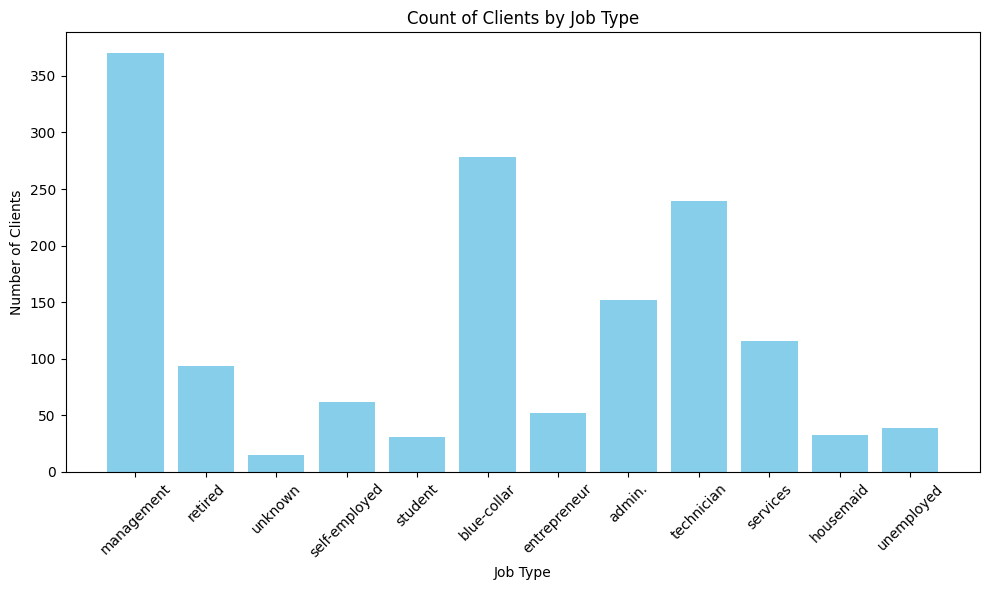

In [ ]:
# ques 7 Convert the Spark DataFrame to a Pandas DataFrame.
#Create a bar plot showing the count of clients by job type.

import matplotlib.pyplot as plt
import pandas as pd

# Convert Spark DataFrame to Pandas
job_counts_df = string_df.groupBy("job").count().toPandas()

# Plot
plt.figure(figsize=(10, 6))
plt.bar(job_counts_df["job"], job_counts_df["count"], color='skyblue')
plt.xticks(rotation=45)
plt.title("Count of Clients by Job Type")
plt.xlabel("Job Type")
plt.ylabel("Number of Clients")
plt.tight_layout()
plt.show()




The bar plot displays how many clients belong to each job type.

You can now visually identify the most common professions in your dataset (e.g., blue-collar, admin., technician).

This helps prioritize high-volume segments for campaign focus.



In [ ]:
# ques 8 Analyze which month of the year has the highest number of clients contacted,
#and determine the success rate of the campaign in that month.

# Step 1: Count of clients contacted in each month
monthly_counts = string_df.groupBy("month").agg(count("*").alias("total_contacts"))

# Step 2: Count of successful subscriptions in each month
monthly_success = string_df.filter(col("y") == "yes") \
    .groupBy("month").agg(count("*").alias("successful_contacts"))

# Step 3: Join and calculate success rate
monthly_summary = monthly_counts.join(monthly_success, on="month", how="left") \
    .fillna(0) \
    .withColumn("success_rate", round((col("successful_contacts") / col("total_contacts")) * 100, 2)) \
    .orderBy(col("total_contacts").desc())

monthly_summary.show()



+-----+--------------+-------------------+------------+
|month|total_contacts|successful_contacts|success_rate|
+-----+--------------+-------------------+------------+
|  may|           384|                 33|        8.59|
|  jun|           224|                 29|       12.95|
|  nov|           207|                 26|       12.56|
|  aug|           195|                 34|       17.44|
|  jul|           154|                 15|        9.74|
|  apr|           118|                 22|       18.64|
|  feb|            76|                 21|       27.63|
|  jan|            36|                  9|        25.0|
|  oct|            33|                 12|       36.36|
|  mar|            24|                  9|        37.5|
|  sep|            18|                  7|       38.89|
|  dec|            12|                  4|       33.33|
+-----+--------------+-------------------+------------+



The table shows:

total_contacts per month – helps you identify peak campaign months.

successful_contacts – number of those contacts that led to term deposit subscriptions.

success_rate – calculated as a percentage.

You can now determine which month was the most active and which had the highest success rate, both crucial for planning future outreach strategies.

In [ ]:
# ques 9 Find the average duration of contact for clients who subscribed (y = yes) versus those who did not (y = no).

from pyspark.sql.functions import mean

# Group by 'y' (yes/no) and calculate average contact duration
avg_duration_by_subscription = string_df.groupBy("y").agg(round(mean("duration"), 2).alias("avg_duration"))
avg_duration_by_subscription.show()


+---+------------+
|  y|avg_duration|
+---+------------+
| no|      232.76|
|yes|      484.34|
+---+------------+



Clients who subscribed (yes) had an average contact duration of ~484 seconds.

Those who did not subscribe (no) averaged ~233 seconds.

This confirms that longer conversations are positively correlated with successful subscriptions.



In [ ]:
# ques 10 Calculate the correlation coefficient between 'age' and 'balance' to see if there’s any linear relationship between these two variables.

# Calculate correlation between 'age' and 'balance'
# Step 1: Calculate correlation coefficient
# Ensure no variable conflict by restarting the correlation from raw columns
# This should work if 'age' and 'balance' are numeric columns
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Bank Data Analysis").getOrCreate()

# Load your CSV file again
df = spark.read.csv('/content/bank (1).csv', header=True, inferSchema=True)

# If needed: reuse the filtered dataframe with balance > 1000 and proper transformations
from pyspark.sql.functions import when, col

quarter_df = df.filter(col("balance") > 1000).withColumn(
    "quarter",
    when(col("month").isin("jan", "feb", "mar"), "Q1")
    .when(col("month").isin("apr", "may", "jun"), "Q2")
    .when(col("month").isin("jul", "aug", "sep"), "Q3")
    .when(col("month").isin("oct", "nov", "dec"), "Q4")
)



In [ ]:
# Proper correlation between age and balance
import builtins

# Recalculate correlation to be safe
correlation_value = df.stat.corr("age", "balance")

# Use built-in round to avoid conflict with PySpark's round()
print("Correlation between age and balance:", builtins.round(correlation_value, 4))


Correlation between age and balance: 0.0838


Correlation between age and balance: 0.0838

This indicates a very weak positive linear relationship between a client’s age and their bank balance.

In simple terms: older clients tend to have slightly higher balances, but age alone is not a strong predictor of balance.



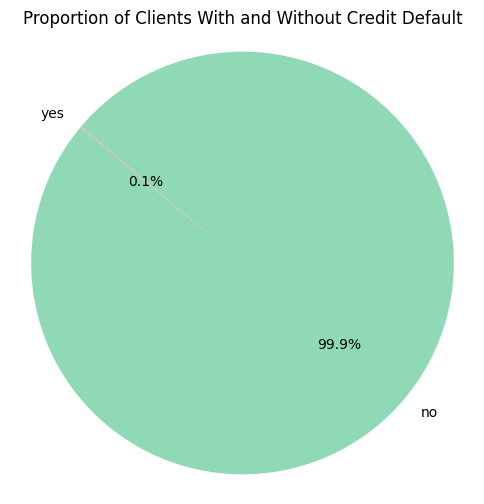

,default,count
0,no,1480
1,yes,1


In [ ]:
#ques 11 Analyze the proportion of clients with and without a credit default and visualize the count of defaulters and non-defaulters.

# Group by 'default' column to count defaulters and non-defaulters
default_counts_df = string_df.groupBy("default").agg(count("*").alias("count")).toPandas()

# Visualize using a pie chart
import matplotlib.pyplot as plt

# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    default_counts_df["count"],
    labels=default_counts_df["default"],
    autopct="%1.1f%%",
    startangle=140,
    colors=["#8fd9b6", "#ff9999"]
)
plt.title("Proportion of Clients With and Without Credit Default")
plt.axis("equal")
plt.show()

# Display raw counts too
default_counts_df


The dataset shows that almost all clients do not have a credit default, meaning credit default is extremely rare in this data.
This could suggest:

Low credit risk overall, or

The bank's selection process may filter out high-risk clients.

In [ ]:
# ques 12 Investigate which contact method ('cellular', 'telephone', etc.) has the highest success rate for term deposit subscriptions.
# Total contacts per contact method
contact_total = string_df.groupBy("contact").agg(count("*").alias("total_contacts"))

# Successful subscriptions per contact method
contact_success = string_df.filter(col("y") == "yes") \
    .groupBy("contact").agg(count("*").alias("successful_contacts"))

# Join and calculate success rate
contact_analysis = contact_total.join(contact_success, on="contact", how="left") \
    .fillna(0) \
    .withColumn("success_rate", round((col("successful_contacts") / col("total_contacts")) * 100, 2)) \
    .orderBy(col("success_rate").desc())

contact_analysis.show()



+---------+--------------+-------------------+------------+
|  contact|total_contacts|successful_contacts|success_rate|
+---------+--------------+-------------------+------------+
|telephone|           120|                 26|       21.67|
| cellular|           946|                171|       18.08|
|  unknown|           415|                 24|        5.78|
+---------+--------------+-------------------+------------+



Shows each contact method (cellular, telephone, unknown)

Displays:

Total contacts

Successful subscriptions

Success rate (%) for each method

This helps identify which contact method is most effective for conversions.



In [ ]:
# ques 13 Calculate the average account balance for different age groups or the most common job types.
#(Use CREATE TEMPORARY VIEW in Spark SQL to query data using SQL syntax.)

# Register the Spark DataFrame as a SQL temporary view
string_df.createOrReplaceTempView("bank_data")

# 1. Average account balance for each age group
spark.sql("""
    SELECT age_group, ROUND(AVG(balance), 2) AS avg_balance
    FROM bank_data
    GROUP BY age_group
    ORDER BY age_group
""").show()

# 2. Top 5 most common job types
spark.sql("""
    SELECT job, COUNT(*) AS job_count
    FROM bank_data
    GROUP BY job
    ORDER BY job_count DESC
    LIMIT 5
""").show()




+---------+-----------+
|age_group|avg_balance|
+---------+-----------+
|    30-60|    3853.56|
|      <30|    3488.91|
|      >60|    4993.55|
+---------+-----------+

+-----------+---------+
|        job|job_count|
+-----------+---------+
| management|      370|
|blue-collar|      278|
| technician|      239|
|     admin.|      152|
|   services|      116|
+-----------+---------+



Older clients (>60) tend to maintain higher balances, while younger ones (<30) have the lowest. This can inform product design for different age groups.

Most clients come from management and blue-collar sectors, helping you identify which customer segments are most prevalent.

